In [4]:
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Conv2DTranspose, concatenate, Activation, MaxPooling2D, Conv2D, BatchNormalization
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import utils
from google.colab import files
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import VGG16
import numpy as np
from PIL import Image


# Это наша метрика на Tensorflow

def dice_coef(y_true, y_pred):
    return (2. * K.sum(y_true * y_pred) + 1.) / (K.sum(y_true) + K.sum(y_pred) + 1.)


In [5]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


Открываем архив (это зависит от архива)

In [6]:
import zipfile
import io
zf = zipfile.ZipFile("/gdrive/My Drive/Colab Notebooks/22655_29047_bundle_archive.zip")
name_files = []
for f in zf.infolist():
    #print(f.filename, f.file_size)
    name_files.append((f.filename, f.file_size))
    if f.filename == "README":
        print(zf.read(f))
zf.extractall()
print(f'size ={len(name_files)}', name_files[0] )

size =6950 ('cityscapes_data/cityscapes_data/train/1.jpg', 32121)


Прочитаем в список названия распакованных  файлов 

Задаю маршрут для чтения

In [7]:
PAHT_train = '/content/cityscapes_data/train/'
PAHT_val = '/content/cityscapes_data/val/'
  

In [8]:
import os, fnmatch
train_img_files = os.listdir(PAHT_train)
val_img_files = os.listdir(PAHT_val)
print(f'size train={len(train_img_files)}', train_img_files[0] )
print(f'size val={len(val_img_files)}', val_img_files[0] )

size train=2975 1190.jpg
size val=500 451.jpg


#Загружаем и уменьшаем картинки

можно обойтись исходным рахзмером или взять другой

ВАЖНО - размер по обеим сторонам должен делиться на 2 несколько раз (сколько будет сжатий кадра)

In [9]:
def load_images(PAHT_image, list_files_name, image_size):
  images = []
  for name in list_files_name:
    images.append(image.load_img(PAHT_image+name ,target_size=image_size))
  return images


In [10]:
imgs_tr = load_images(PAHT_train, train_img_files, image_size  = (256,512))
imgs_vl = load_images(PAHT_val, val_img_files, image_size  = (256,512))
print(f'size imges_train={len(imgs_tr)}', imgs_tr[0].size )
print(f'size imges_vl={len(imgs_vl)}', imgs_vl[0].size )

size imges_train=2975 (512, 256)
size imges_vl=500 (512, 256)


Посмотрели на входные кадры train и val

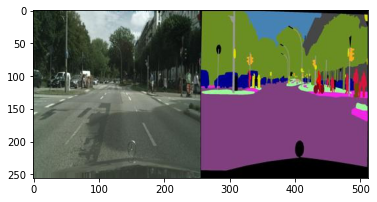

In [11]:
plt.imshow(imgs_tr[0].convert('RGBA'))
plt.show()

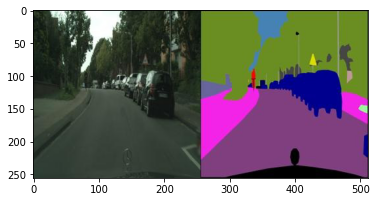

In [12]:
plt.imshow(imgs_vl[0].convert('RGBA'))
plt.show()

Переразобьем масссивы train и val, разделив метки и данные

In [65]:
def load_scissors(list_images, x_sc):
  images_one = []
  images_too = []
  for img in list_images:
    images_one.append(img.crop((0,0,x_sc,256)).resize((64,64),Image.NEAREST))
    images_too.append(img.crop((x_sc,0,img.size[0],256)).resize((64,64),Image.NEAREST))
  return images_one, images_too

size im_tr_data=2975 (64, 64)


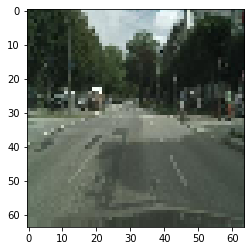

size im_tr_lb=2975 (64, 64)


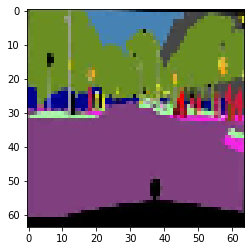

In [66]:
im_tr_data, im_tr_lb = load_scissors(imgs_tr, 256)
print(f'size im_tr_data={len(im_tr_data)}', im_tr_data[0].size)
plt.imshow(im_tr_data[0].convert('RGBA'))
plt.show()
print(f'size im_tr_lb={len(im_tr_lb)}', im_tr_lb[0].size)
plt.imshow(im_tr_lb[0].convert('RGBA'))
plt.show()

size im_vl_data=500 (64, 64)


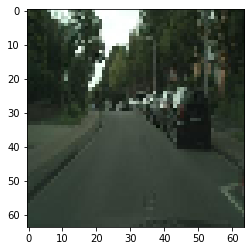

size im_vl_lb=500 (64, 64)


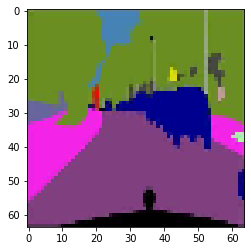

In [67]:
im_vl_data, im_vl_lb = load_scissors(imgs_vl, 256)
print(f'size im_vl_data={len(im_vl_data)}', im_vl_data[0].size)
plt.imshow(im_vl_data[0].convert('RGBA'))
plt.show()
print(f'size im_vl_lb={len(im_vl_lb)}', im_vl_lb[0].size)
plt.imshow(im_vl_lb[0].convert('RGBA'))
plt.show()

In [68]:
import cv2

In [72]:
aim=[]
for im in im_tr_lb:
  hsv_img = cv.cvtColor(np.array(im).astype(np.uint8), cv2.COLOR_RGB2HSV)
  aim.append(hsv_img.reshape(-1, hsv_img.shape[2]))
aim=np.array(aim)
aim.shape

(2975, 4096, 3)

In [73]:
aim = aim.reshape(-1, aim.shape[2])
aim.shape

(12185600, 3)

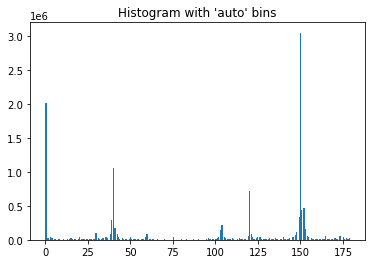

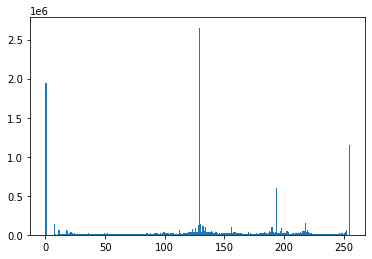

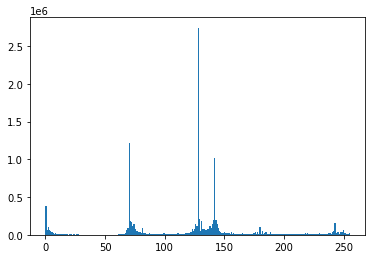

In [74]:
plt.title("Histogram with 'auto' bins")
plt.hist(aim[:,0], bins=256)
plt.show()
plt.hist(aim[:,1], bins=256) 
plt.show()
plt.hist(aim[:,2], bins=256)   # arguments are passed to np.histogram
plt.show()

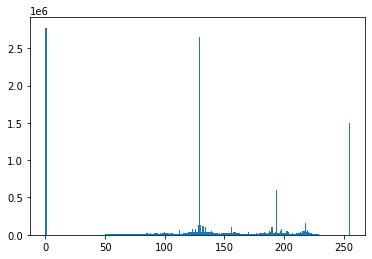

In [75]:
aim[:,1][aim[:,1]<50]=0
aim[:,1][aim[:,1]>=230]=255
plt.hist(aim[:,1], bins=256) 
plt.show()

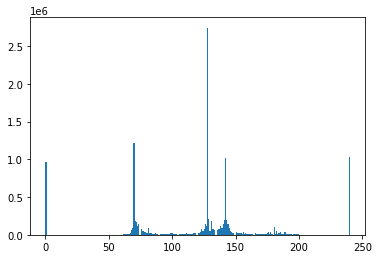

In [76]:
aim[:,2][aim[:,2]<60]=0
aim[:,2][aim[:,2]>=200]=240
plt.hist(aim[:,2], bins=256) 
plt.show()

In [77]:
from sklearn import cluster

In [78]:
k_means = cluster.KMeans(n_clusters=13, n_init=4)

In [79]:
k_means.fit(aim[:10000000])
values = k_means.cluster_centers_.squeeze()
labels = k_means.labels_
values=np.round(values,0)
print('HSV цвета ', values)

HSV цвета  [[150. 127. 128.]
 [  1.   1.   0.]
 [ 25. 225. 238.]
 [155. 216. 237.]
 [126. 253. 125.]
 [ 40. 114. 119.]
 [ 44. 246.   1.]
 [  6.   1.  73.]
 [ 31.  76. 226.]
 [ 39. 192. 141.]
 [123.   8.  82.]
 [139. 237.   1.]
 [114. 147. 179.]]


In [ ]:
labels = []
i=0
for im in aim.reshape(2975,4096,3):#65536,3):
  if i%100==0: print(i)  # оставим для обучения 100 примеров
  if i ==100: break
  pr=k_means.predict(im)
  temp = []
  for l,p in zip(pr,im):
    temp.append(values[l])
  res_im=np.array(temp).astype(np.uint8)
  res_im=res_im.reshape(64,64,3)
  labels.append(res_im)
  i+=1
labels=np.array(labels)
labels.shape

In [81]:
temp = cv.cvtColor(labels[0], cv2.COLOR_HSV2RGB)
temp.shape

(64, 64, 3)

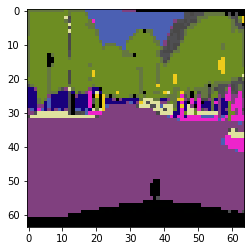

In [82]:
plt.imshow(temp)
plt.show()

In [ ]:
#numpy.unique(np.array(im_vl_lb[0].reshape(-1, np.array(im_vl_lb[0].shape[2]), axis=0)

In [ ]:
 #colors = [(255,0,0), (0,255,0), (0,0,255),
             (255,255,0), (255,0,255), (0,255,255),
             (255,255,255), (200,50,0),(50,200,0),
             (50,0,200), (200,200,50), (0,50,200),
             (0,200,50), (0,0,0)]
#col_=np.array(colors)

#Создаём обучающую выборку

Собираем входные примеры:

In [83]:
def make_arr(list_images): 
  arr = []
  for img in list_images:
    x = image.img_to_array(img)
    arr.append(x/255) 
  return np.array(arr)

In [84]:
xTrain_Test = make_arr(im_tr_data)
print(xTrain_Test.shape)

(2975, 64, 64, 3)


Делаем конвертер в one-hot_encoding для выходных примеров

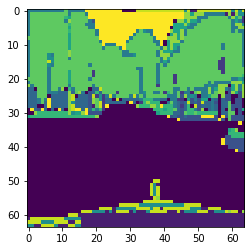

[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


In [85]:
def Color2index(y):
  arr_col=values.copy()#[[0,0,255],[255,0,0],[255,255,0],[0,255,0],[255,0,255],[0,255,255],[255,0,153],[153,0,255],[0,153,255],[153,255,0],[255,153,0],[0,255,153],[0,153,153],[0,0,0]]
  y_ind = np.zeros((y.shape[0],y.shape[1]))
  y_cat = np.zeros((y.shape[0],y.shape[1], len(arr_col)))
  i = 1
  for i_color in arr_col:
    ind_i = np.where((y[:,:,0]==i_color[0])&(y[:,:,1]==i_color[1])&(y[:,:,2]==i_color[2]))
    y_ind[ind_i[0],ind_i[1]] = i
    y_cat[ind_i[0],ind_i[1], i-1] = 1 
    i += 1 
  return y_cat, y_ind, i-1

cat_yi,ind_yi,h = Color2index(labels[0])
plt.imshow(ind_yi.astype(float)/h)
plt.show()  
print(cat_yi[0][0])

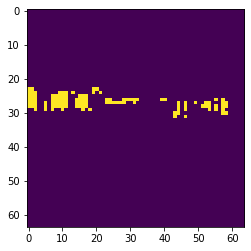

In [91]:
plt.imshow(cat_yi[:,:,4])
plt.show()

Сегментированную картинку в  One hot encoding

In [87]:
yTrain_Test = []

for seg in labels:
  y_cat,_,_ = Color2index(image.img_to_array(seg))
  yTrain_Test.append(y_cat)

yTrain_Test = np.array(yTrain_Test)

In [88]:
print(yTrain_Test.shape)

(100, 64, 64, 13)


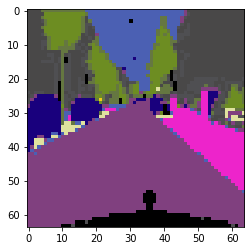

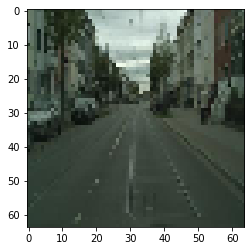

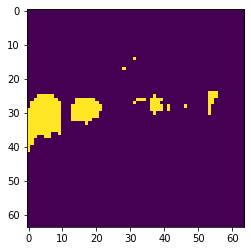

In [92]:
n = 10
plt.imshow(cv.cvtColor(labels[n], cv2.COLOR_HSV2RGB))
plt.show()
plt.imshow((xTrain_Test[n]*255).astype(np.uint8))
plt.show()
img = yTrain_Test[n][:,:,4] # класс  42 - машины 
plt.imshow(img.astype(float)) 
plt.show()

Делим на тест и трейн по числу N

In [93]:
N = 75
yTrain = yTrain_Test[:N,:,:,:]
xTrain = xTrain_Test[:N,:,:,:]

yTest = yTrain_Test[N:,:,:,:]
xTest = xTrain_Test[N:,:,:,:]

In [94]:
yTest.shape

(25, 64, 64, 13)

In [95]:
print(xTrain.shape)
print(yTrain.shape)

(75, 64, 64, 3)
(75, 64, 64, 13)


#Создаём и обучаем U-net

In [56]:
from tensorflow.keras.utils import plot_model

**Unet**

In [195]:
def cuttedUnet(num_classes = len(values), input_shape= (64, 64, 3)):
    img_input = Input(input_shape)

    # Block 1
    x = Conv2D(32, (3, 3), padding='same', name='block1_conv1')(img_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(32, (3, 3), padding='same', name='block1_conv2')(x)
    x = BatchNormalization()(x)
    # запомним тензор для переноса
    block_1_out = Activation('relu')(x)

    x = MaxPooling2D()(block_1_out)

    # Block 2
    x = Conv2D(64, (3, 3), padding='same', name='block2_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64, (3, 3), padding='same', name='block2_conv2')(x)
    x = BatchNormalization()(x)
    # запомним тензор для переноса
    block_2_out = Activation('relu')(x)

    x = MaxPooling2D()(block_2_out)

    # Block 3
    x = Conv2D(128, (3, 3), padding='same', name='block3_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(128, (3, 3), padding='same', name='block3_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(128, (3, 3), padding='same', name='block3_conv3')(x)
    x = BatchNormalization()(x)
    # запомним тензор для переноса
    block_3_out = Activation('relu')(x)

    x = MaxPooling2D()(block_3_out)

    # Block 4
    x = Conv2D(256, (3, 3), padding='same', name='block4_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same', name='block4_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same', name='block4_conv3')(x)
    x = BatchNormalization()(x)
    # запомним тензор для переноса
    block_4_out = Activation('relu')(x)

    # UP 2
    x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # добавили перенос из понижаюшего плеча
    x = concatenate([x, block_3_out])
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 3
    x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # добавили перенос из понижаюшего плеча
    x = concatenate([x, block_2_out])
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 4
    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # добавили перенос из понижаюшего плеча
    x = concatenate([x, block_1_out])
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # слой классификатор
    x = Conv2D(num_classes, (3, 3), activation='softmax', padding='same')(x)

    model = Model(img_input, x)
    model.compile(optimizer=Adam(),
                  loss='categorical_crossentropy',
                  metrics=[dice_coef])
    model.summary()
    return model

Model: "functional_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 64, 64, 32)   896         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_76 (BatchNo (None, 64, 64, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
activation_76 (Activation)      (None, 64, 64, 32)   0           batch_normalization_76[0][0]     
_______________________________________________________________________________________

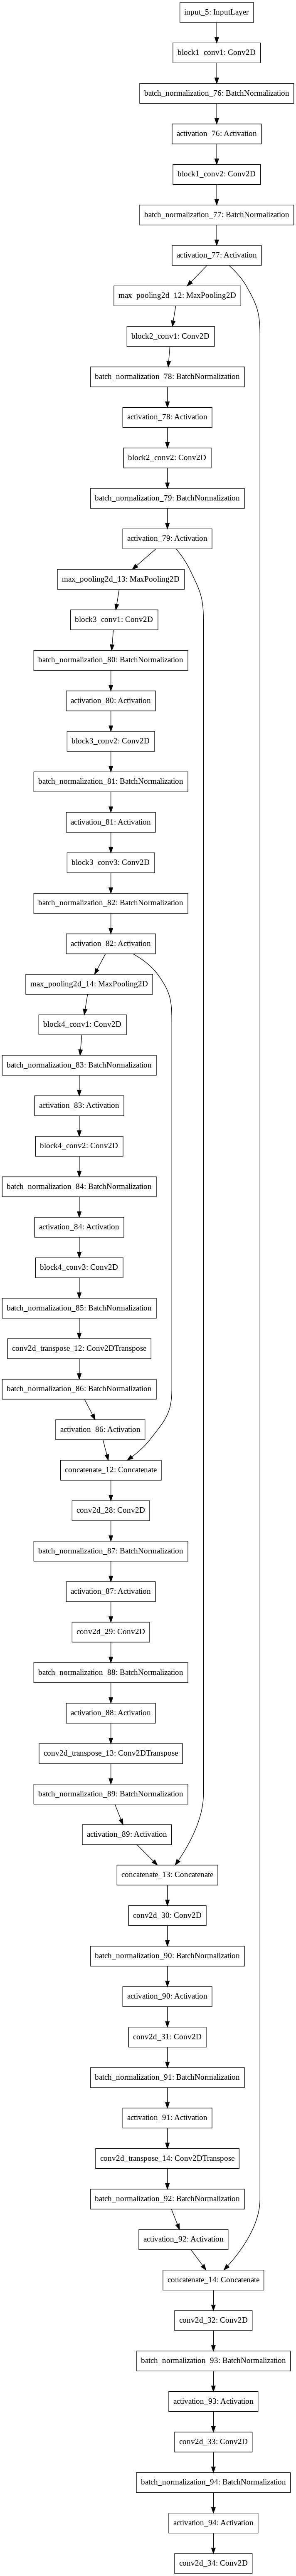

In [196]:
modelC = cuttedUnet(len(values), (64, 64, 3))

plot_model(modelC, to_file='modelC.png')

In [197]:

history = modelC.fit(xTrain, yTrain, epochs=50, batch_size=3, validation_data=(xTrain, yTrain))

Epoch 1/50
25/25 [==============================] - 17s 689ms/step - loss: 1.7462 - dice_coef: 0.3322 - val_loss: 2.2230 - val_dice_coef: 0.1395
Epoch 2/50
25/25 [==============================] - 18s 715ms/step - loss: 1.3040 - dice_coef: 0.4518 - val_loss: 1.8310 - val_dice_coef: 0.2324
Epoch 3/50
25/25 [==============================] - 18s 710ms/step - loss: 1.1878 - dice_coef: 0.4983 - val_loss: 2.5780 - val_dice_coef: 0.2822
Epoch 4/50
25/25 [==============================] - 19s 741ms/step - loss: 1.1547 - dice_coef: 0.4946 - val_loss: 1.9023 - val_dice_coef: 0.3592
Epoch 5/50
25/25 [==============================] - 18s 726ms/step - loss: 1.0827 - dice_coef: 0.5301 - val_loss: 1.8167 - val_dice_coef: 0.4138
Epoch 6/50
25/25 [==============================] - 22s 875ms/step - loss: 1.0706 - dice_coef: 0.5256 - val_loss: 1.7913 - val_dice_coef: 0.4077
Epoch 7/50
25/25 [==============================] - 22s 862ms/step - loss: 1.0494 - dice_coef: 0.5510 - val_loss: 2.1291 - val_dic

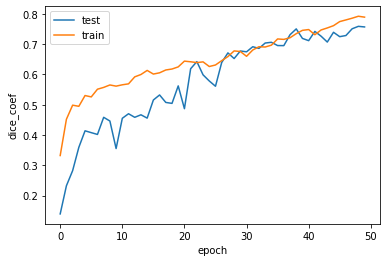

In [198]:
plt.plot(history.history['val_dice_coef'],label = 'test')
plt.plot(history.history['dice_coef'],label='train')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('dice_coef')
plt.show()

In [204]:
pred = modelC.predict(xTest[:5])
print(pred.shape)

(5, 64, 64, 13)


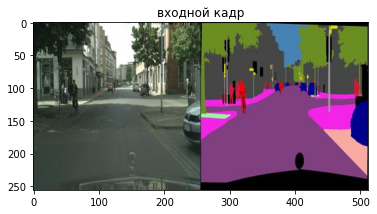

In [209]:
n = 3
class_ =4
plt.imshow(imgs_tr[N+n].convert('RGBA'))
plt.title('входной кадр')
plt.show()

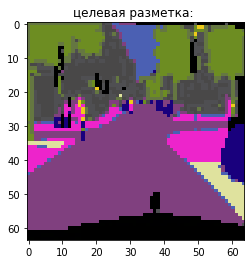

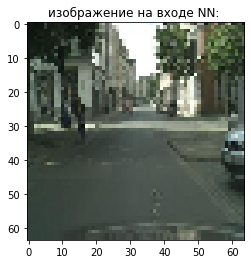

(64, 64, 3)


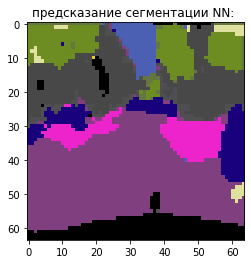

In [210]:
plt.title('целевая разметка: ')
plt.imshow(cv.cvtColor(labels[N+n], cv2.COLOR_HSV2RGB))
plt.show()

plt.title('изображение на входе NN: ')
plt.imshow((xTrain_Test[N+n]*255).astype(np.uint8))
plt.show()

plt.title('предсказание сегментации NN: ')
pr= pred[n]
pr= pr.reshape(-1, pr.shape[2])
z = []
for x  in pr:
  z.append(np.argmax(x))
z = np.array(z)
img = np.zeros_like(xTrain[0])
img = img.reshape(4096,3)
img=values[z]
img=img.reshape(64,64,3)
print(img.shape)

plt.imshow(cv.cvtColor(img.astype(np.uint8), cv2.COLOR_HSV2RGB))
plt.show()


Кувыркался с разметкой нерельно долго (странно, что датасет такой кривой), что-то видимо делаю  кривыми руками. Сдаю что есть, видно что сжатие картинки  здорово все ухудшило, вместе с тем, какой-никакой результат вылез... Можно еще поучить, но времени больше нет. 